In [25]:
suppressPackageStartupMessages({
  library(dplyr)
  library(dataorganizer)
  library(devtools)
  library(cellAdmix)
  library(ggplot2)
  library(readr)
  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [4]:
# load data
data <- prepare_BC_sc_spatial()
df <- data$df_spatial
cell_annot <- data$cell_annot
so_rna <- data$so_rna

In [5]:
base_dir <- CachePath('BC_scaled_dat4/')

k_joint <- c(5,15,20,30)
k_ct <- c(5)

In [6]:
# load NMF and CRF results
res <- load_nmf_crf_multi(k_joint, k_ct, base_dir)
all_nmf <- res[[1]]
crf_all <- res[[2]]

In [7]:
# load saved enrichment results
enr_res_all <- readRDS(paste0(base_dir, 'enrich_results.rds'))

In [8]:
# load and extract bridge results
all_ctypes <- unique(cell_annot$celltype)
bridge_res_all <- extract_bridge_multi(
  all_nmf,  all_ctypes=all_ctypes, dir=base_dir,
  bridge_pthresh=.1, bridge_adj_pvals=FALSE
)

In [9]:
fp_checks <- check_fp_multi(
  df,cell_annot,crf_all,enr_res_all=enr_res_all, bridge_res_all=bridge_res_all,
  do_clean=TRUE, knn_k=100, median_thresh=.2
)
annot_res_all <- fp_checks[[1]]
orig_nms_all <- fp_checks[[2]]

In [10]:
# compute cell adj mat ahead of time in case need to rerun dblt function several times
df$cell_type <- df$celltype
sc_ctypes <- unique(so_rna$cell_type)
df_ct_match <- df[df$cell_type %in% sc_ctypes,]
cell_adj_df <- estimate_cell_adjacency(df_ct_match, random.shift=1e-2, n.cores=30)

In [11]:
# now to get genes to exclude based on comparing gene-gene correlations across datasets
so_spatial <- get_counts_meta_seurat(df)
so_spatial <- NormalizeData(so_spatial)
common_genes <- intersect(rownames(so_rna), rownames(so_spatial))
length(common_genes)

so_spatial %<>% subset(features=common_genes)
so_rna %<>% subset(features=common_genes)
cor_cors <- estimate_correlation_preservation(so_spatial[['RNA']]$data, so_rna[['RNA']]$data)

Normalizing layer: counts



[1] 313

In [12]:
dbl_score_params <- list(
  signal_thres=0.4,
  exclude_genes=names(cor_cors)[cor_cors<.7],
  p.c=.25,
  min.expr.frac=0.05,
  exclude.cell.types=NULL,
  max.prob.high=0.1
)

In [13]:
# compute admixture probability scores
scores_final_df <- suppressWarnings({
  get_scores_multi(
    annot_res_all, orig_nms_all, dbl_score_params,
    df, so_rna, crf_all, cell_adj_df, n.cores=15
  )
})

Normalizing layer: counts



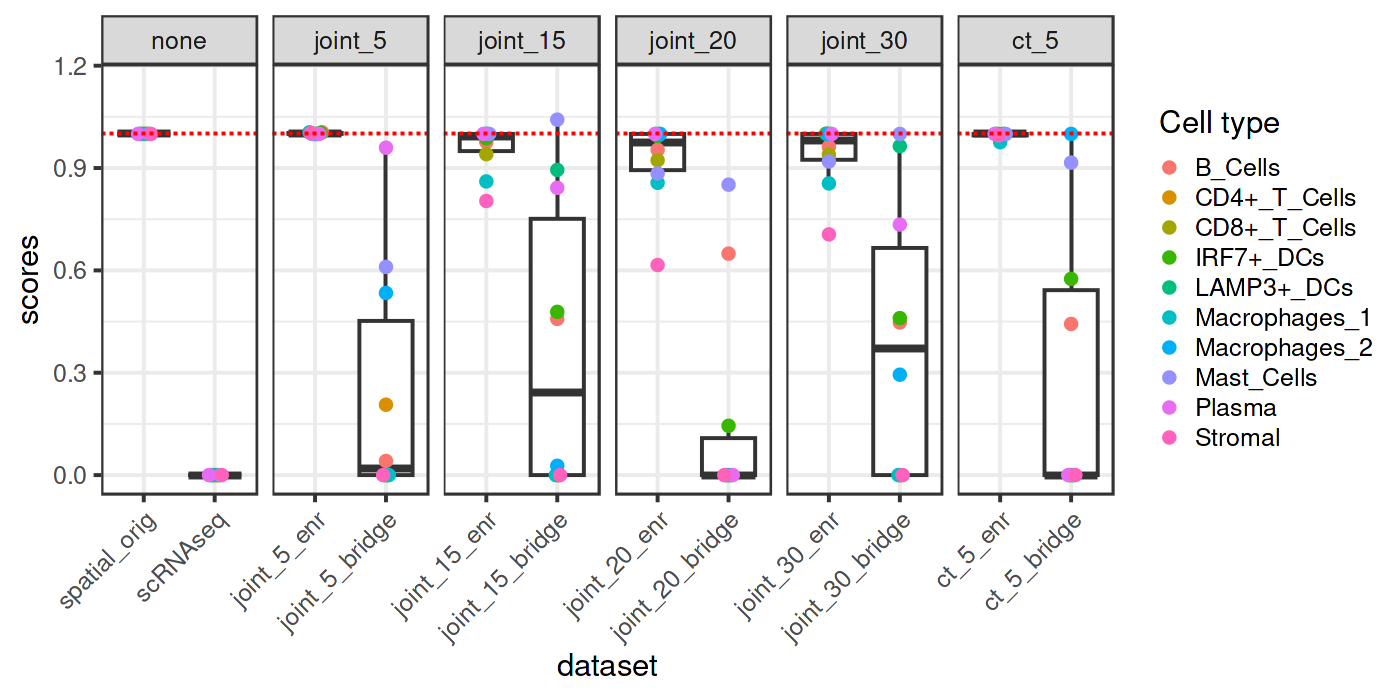

In [14]:
options(repr.plot.width = 7, repr.plot.height = 3.5, repr.plot.res = 200)

p <- plot_ct_av_norm_scores(scores_final_df, trim_level=.9)
p

In [22]:
res_nm <- 'joint_20_bridge'
res_nm_splt <- strsplit(res_nm,split='_')[[1]]
f_rm <- annot_res_all[[res_nm]]
crf_res <- crf_all[[paste0(res_nm_splt[[1]],'_',res_nm_splt[[2]])]]
scores_orig <- scores_final_df[scores_final_df$dataset=='spatial_orig',]
scores_cln <- scores_final_df[scores_final_df$dataset==res_nm,]

plts <- plot_cell_score_ratios(
  scores_orig, scores_cln, f_rm, df, crf_res, upper.lim=1.5, min.mean.thresh=1e-3
)

Picking joint bandwidth of 0.0623



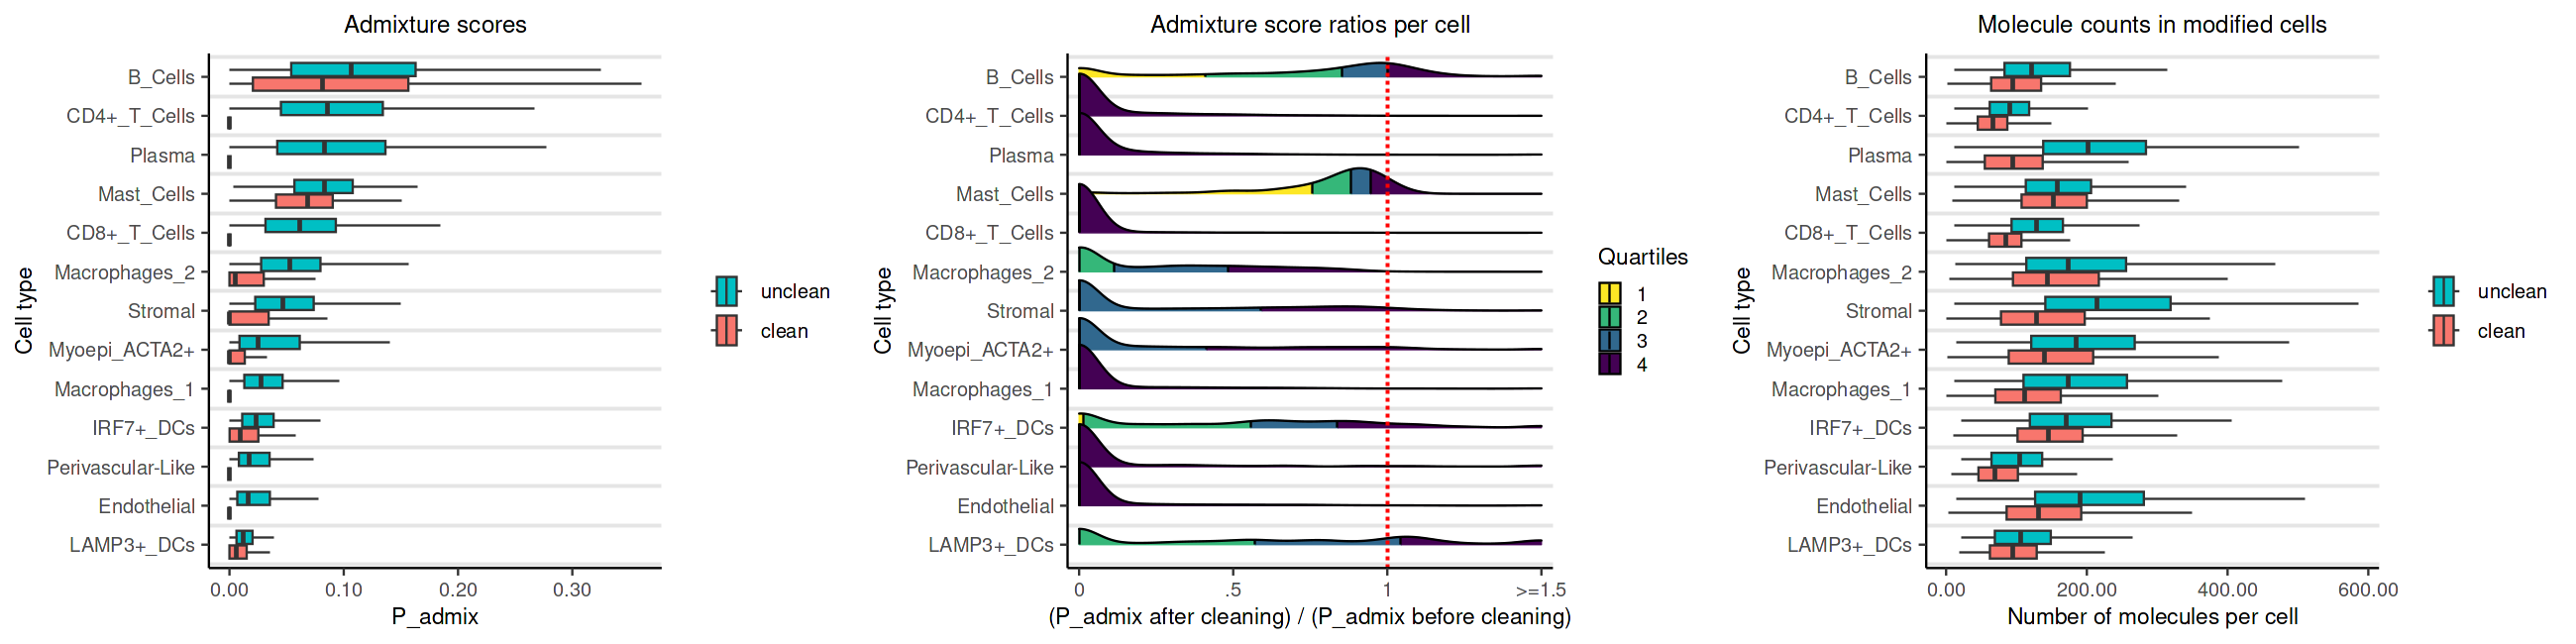

In [23]:
options(repr.plot.width=13, repr.plot.height=3.25, repr.plot.res=200)
fig <- plot_grid(plotlist=plts[c(1,2,4)], nrow=1, align='h')
fig

In [26]:
CachePath('BC_cell_score_ratios2.rds') %>% write_rds(plts[c(1,2,4)], .)